In [26]:
%%bash
scp -r root@47.102.133.195:/usr/local/www/wyydsb/spider/bilibili/data/public.csv ../../spider/bilibili/yybzz_data  

In [27]:
data_dir = '../../spider/bilibili/yybzz_data/'
public_path = '{}public.csv'.format(data_dir)
with open(public_path, 'r') as f:
    public_data = [ii.strip() for ii in f.readlines()]
for ii in range(86):
    jj = public_data[ii]
    public_data[ii] = ','.join([jj.split(',')[0], '0', *jj.split(',')[1:]])
public_data_len = [len(ii.split(',')) for ii in public_data]
max_public_len = max(public_data_len)
public_data = [','.join([str(ii) for ii in range(1, max_public_len + 1)]), *public_data]
with open(public_path, 'w') as f:
    f.write('\n'.join(public_data))

In [50]:
'''prepare data'''
import pandas as pd
import numpy as np
import time

df = pd.read_csv(public_path)

'''one day'''
df['fan'] = df['3'].fillna(0)
df['time'] = df['1'].map(lambda x: x.split(None, 1)[1])
df['fanadd'] = df['4'] - df['3']
df['fanadd'] = df['fanadd'].map(lambda x: x if x > 0 else 0)
df['fanadd_ratio'] = df['fanadd'] / df['3']
df['fanadd_ratio'] = df['fanadd_ratio'].replace(
    [np.inf, -np.inf], np.nan).fillna(0)
df['viewadd'] = (df['18'] - df['6']).fillna(0)
df['viewadd'] = df['viewadd'].map(lambda x: x if x > 0 else 0)
df['viewadd_ratio'] = (df['viewadd'] / df['6']).replace(
    [np.inf, -np.inf], np.nan).fillna(0)
df['view_fan'] = (df['viewadd'] / df['3']).replace(
    [np.inf, -np.inf], np.nan).fillna(0)
df['view_fan_20'] = df['view_fan'].map(lambda x: x if x < 20 else 0)
df['view_fanadd'] = (df['viewadd'] / df['fanadd']).replace(
    [np.inf, -np.inf], np.nan).fillna(0)

''' delete big point '''
df['fan'] = df['fan'].map(lambda x: x if x < 1200000 else None)
df['fan_more10w'] = df['fan'].map(lambda x: x if (x < 1200000 and x > 100000) else None)
df['fanadd'] = df['fanadd'].map(lambda x: x if x < 20000 else None)
df['fanadd_ratio'] = df['fanadd_ratio'].map(lambda x: x if x < 1 else None)
df['viewadd'] = df['viewadd'].map(lambda x: x if x < 100000 else None)
df['view_fan'] = df['view_fan'].map(lambda x: x if x < 50 else None)
df['view_fanadd'] = df['view_fanadd'].map(lambda x: x if x < 1500 else None)
df['viewadd'] = df['viewadd'].map(lambda x: x if x < 100000 else None)
df['viewadd'] = df['viewadd'].map(lambda x: x if x < 100000 else None)

'''seven day'''
df['seven'] = df['1'].map(lambda x: '1970-01-%d %s' % (int(time.strftime(
    "%w", time.strptime(x, "%Y-%m-%d %H:%M:%S"))) + 4, x.split(None, 1)[1]))
need_columns = ['time', 'fan', 'fanadd', 'fanadd_ratio',
                'viewadd', 'viewadd_ratio', 'view_fan', 'view_fan_20', 'view_fanadd', 'seven', 'fan_more10w']
result_df = pd.DataFrame(df, columns=need_columns)
result_df.to_csv('{}public_re.csv'.format(data_dir), index=False)

df['minue'] = df['time'].map(lambda x: x[:-4] + '0:00')
minue = df.groupby('minue').count()
minue.to_csv('{}public_min.csv'.format(data_dir), index=True)


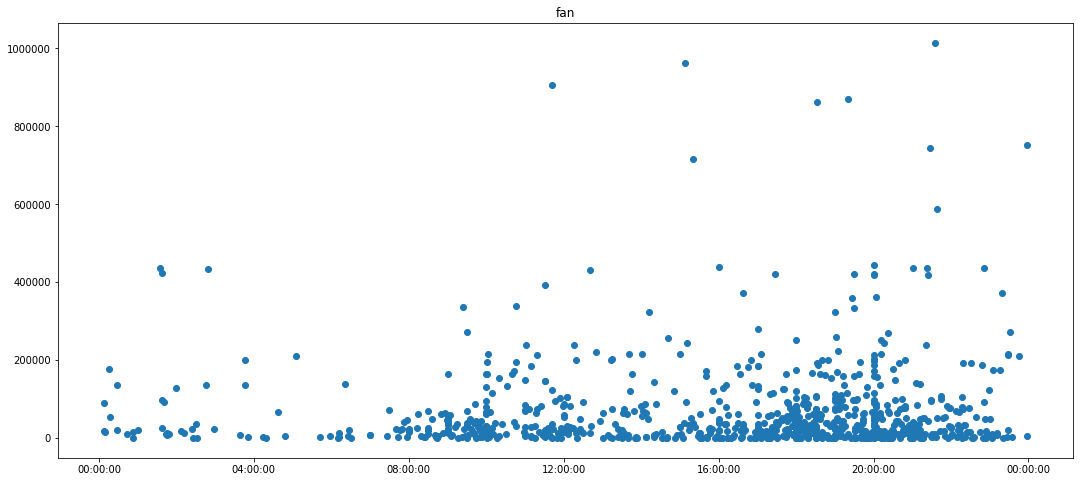

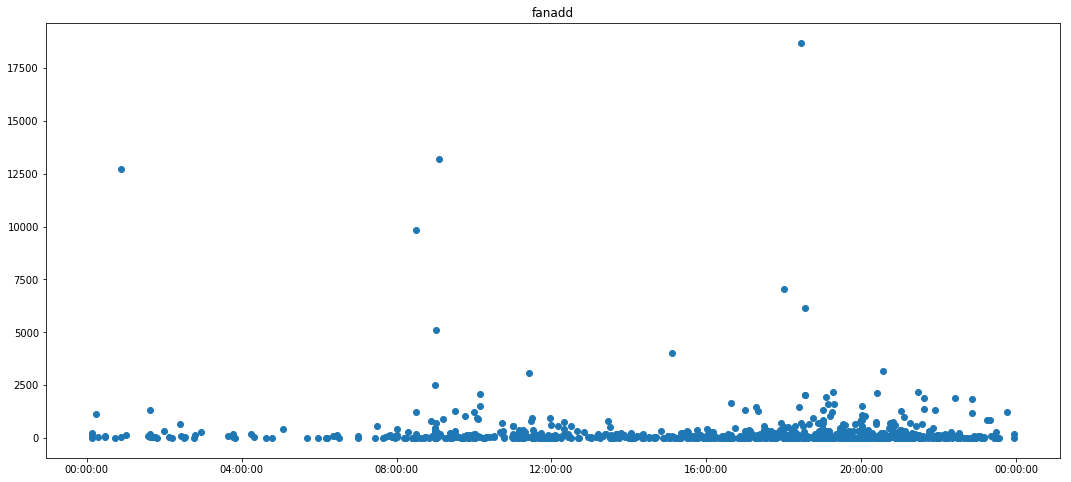

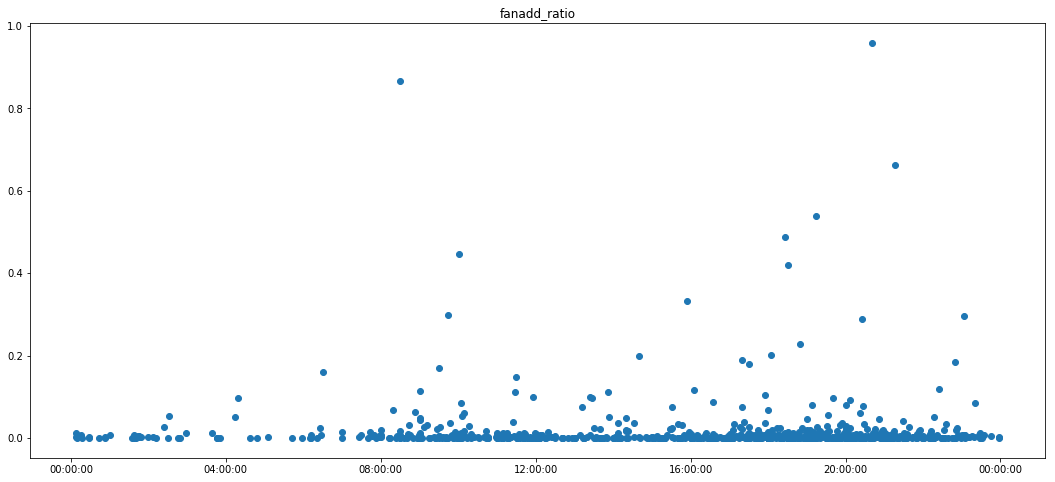

In [47]:
'''drawing fan'''
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter  

plt_df = pd.read_csv('%spublic_re.csv'%data_dir, parse_dates=['time'])


for ii in plt_df.columns[1:4]:
    plt.figure(figsize=(40,8))
    ax = plt.subplot(121)
    plt.plot_date(plt_df.time, plt_df[ii])
    ax.set_title(ii)
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    ax.xaxis.set_major_locator(AutoDateLocator(maxticks=8)) 
plt.show()



可以看出大部分UP主喜欢在晚上8点左右发视频，但在40w体量粉丝左右的UP中，并没有这个规律，他们发视频凌晨、晚上都有。（当然这也意味着40w粉丝在b站因为着食物链上游）。
根据之前的分析，粉丝增加数主要来源于上上近期三日榜，获得的客量
单纯看第一天粉丝增加数，晚上发，首日增加的粉丝数会较多。这主要是因为晚上发能保证到第二天晚上，一定会在近期三日榜取得比较好的名次，保证了在流量最大的晚上发挥出视频因为新鲜度的吸引流量优势。
除了晚上19-20点的小峰值之外，在9点-11点还有一个小峰，但弱于晚上的峰值

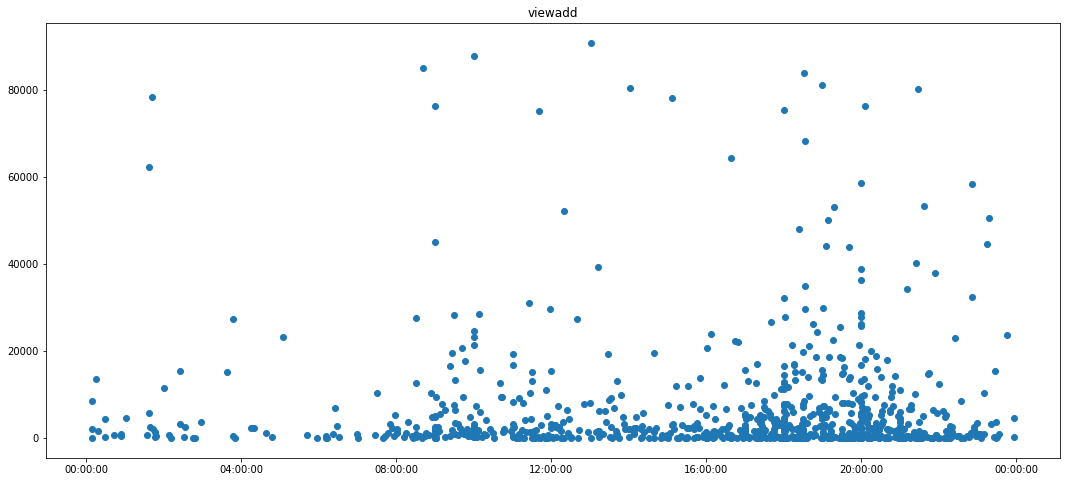

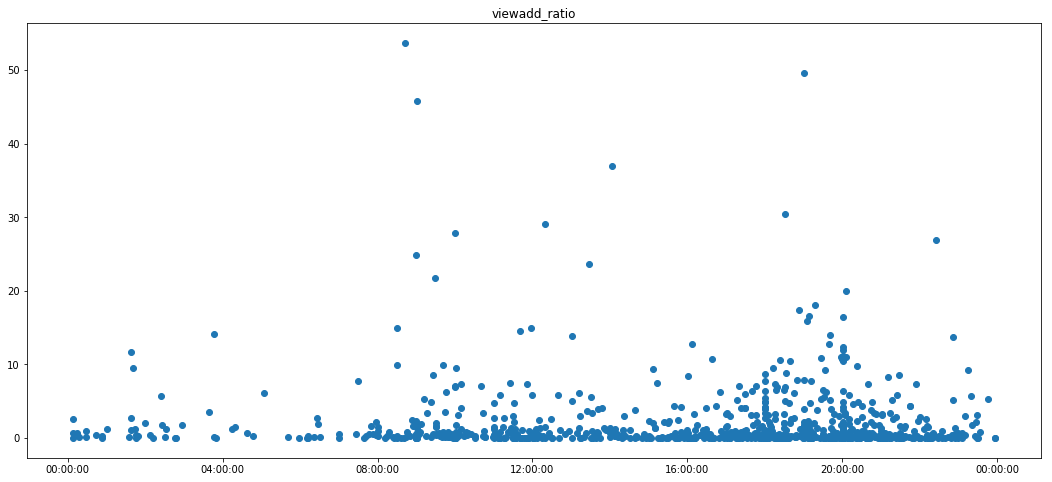

In [36]:
'''view drawing'''
for ii in plt_df.columns[4:6]:
    plt.figure(figsize=(40,8))
    ax = plt.subplot(121)
    plt.plot_date(plt_df.time, plt_df[ii])
    ax.set_title(ii)
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    ax.xaxis.set_major_locator(AutoDateLocator(maxticks=8)) 
plt.show()


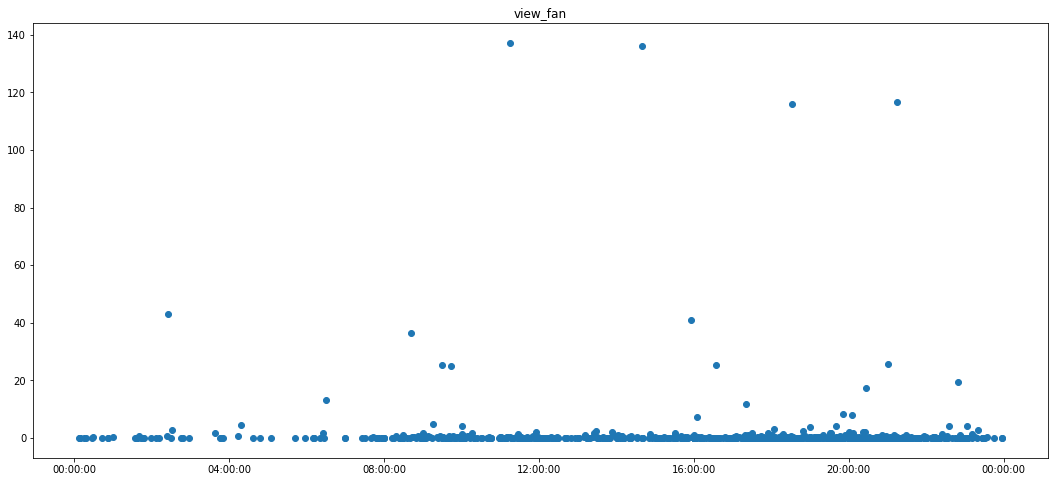

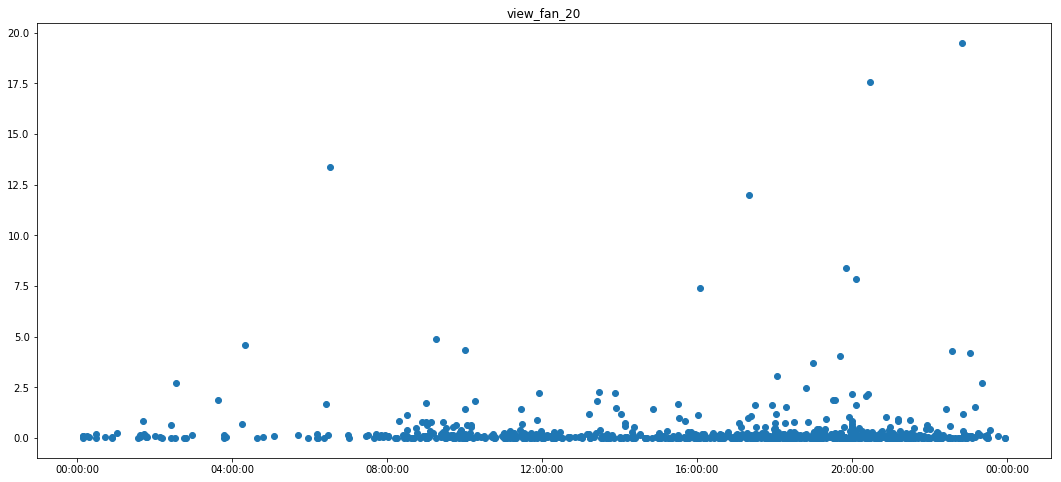

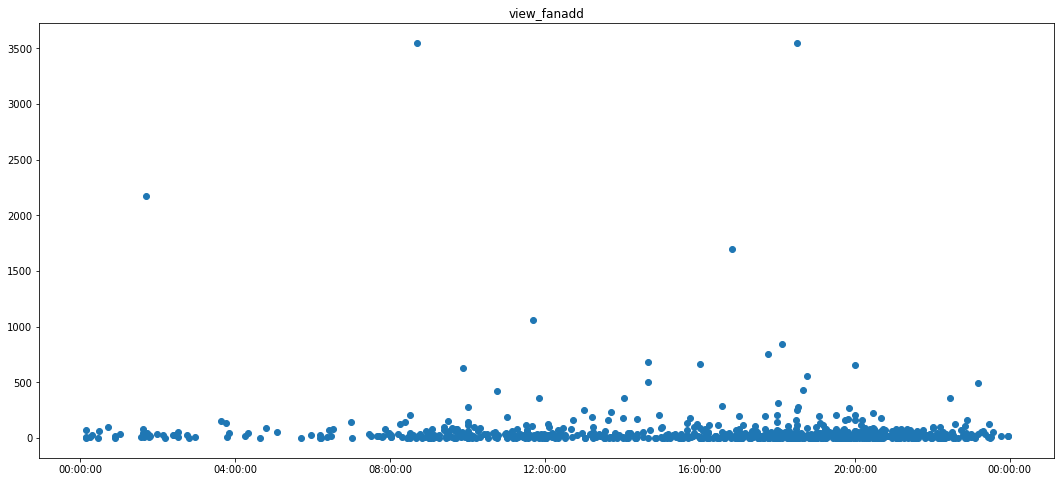

In [37]:
'''view drawing'''
for ii in plt_df.columns[6:9]:
    plt.figure(figsize=(40,8))
    ax = plt.subplot(121)
    plt.plot_date(plt_df.time, plt_df[ii])
    ax.set_title(ii)
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    ax.xaxis.set_major_locator(AutoDateLocator(maxticks=8)) 
plt.show()

从上图可以看出，访问量和粉丝数基本成正比。
去除大于`访问量增加量/粉丝数 >20`的点得到 plt`view_fan_20`
还是可以看到晚上发单位粉丝访问量普遍要高一点

同样可以看出流量增加分布和粉丝增加分布较为相似，存在两个峰值。
看具体数量单日访问量大于2w已经是穿搭类少数UP主能达到的水平。
访问量增加率也是晚上更高一些

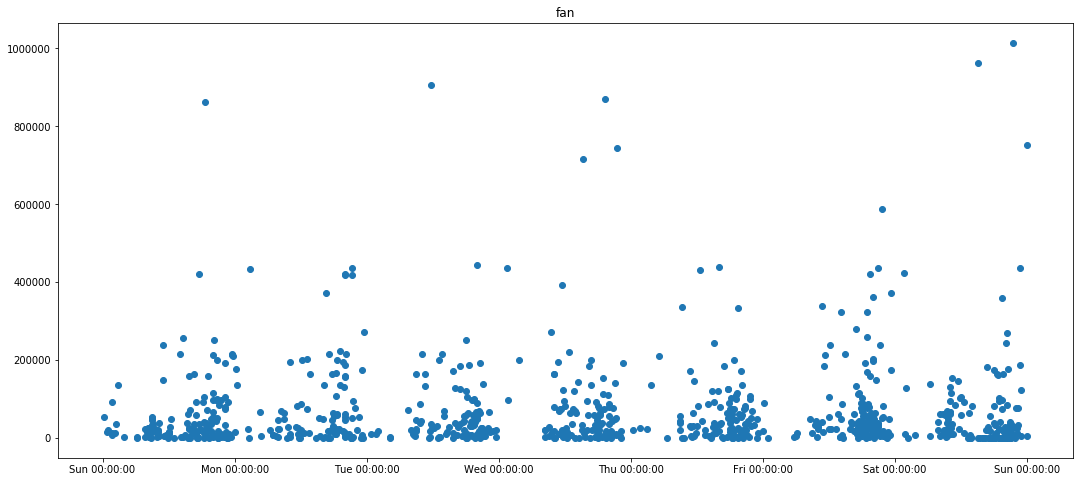

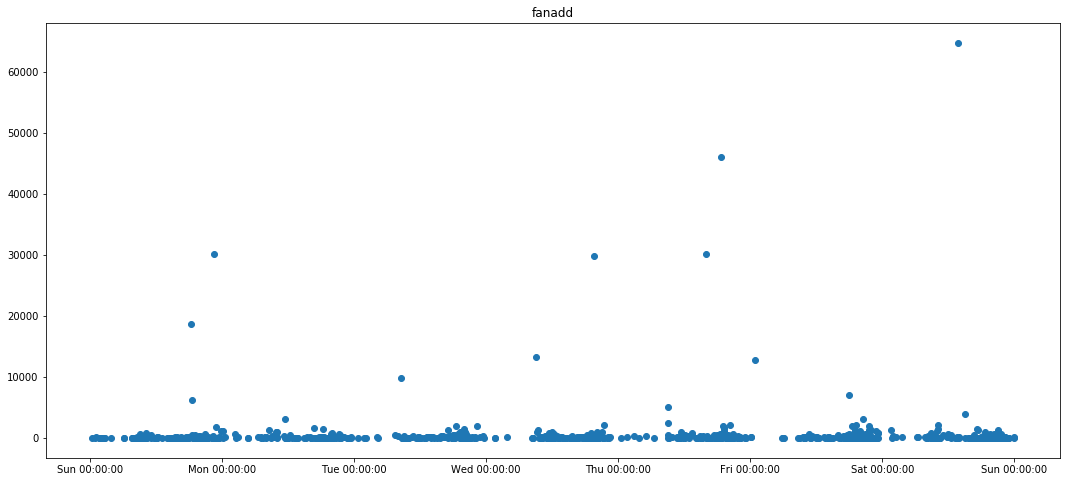

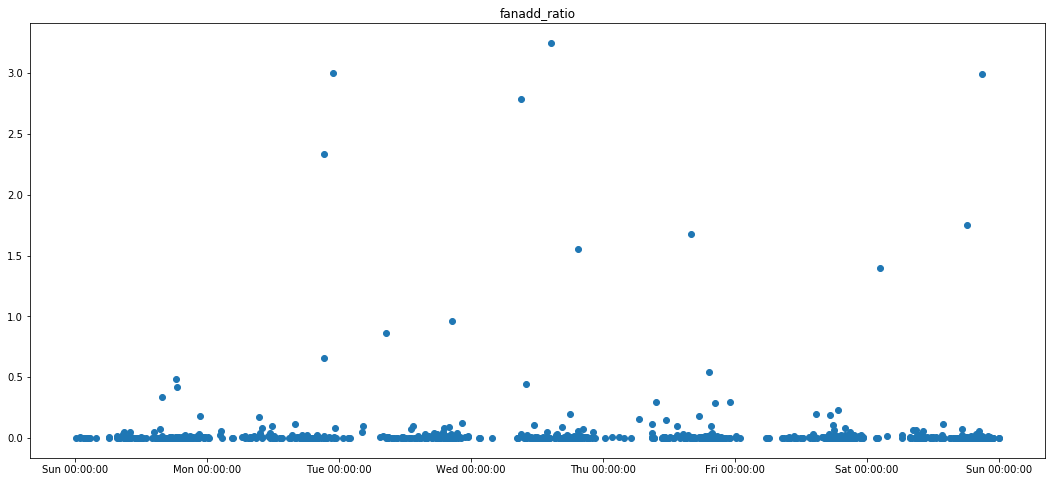

In [38]:
'''seven fan drawing'''
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter  

plt_df = pd.read_csv('%spublic_re.csv'%data_dir, parse_dates=['seven'])


for ii in plt_df.columns[1:4]:
    plt.figure(figsize=(40,8))
    ax = plt.subplot(121)
    plt.plot_date(plt_df.seven, plt_df[ii])
    ax.set_title(ii)
    ax.xaxis.set_major_formatter(DateFormatter('%a %H:%M:%S'))
    ax.xaxis.set_major_locator(AutoDateLocator(maxticks=8)) 
plt.show()

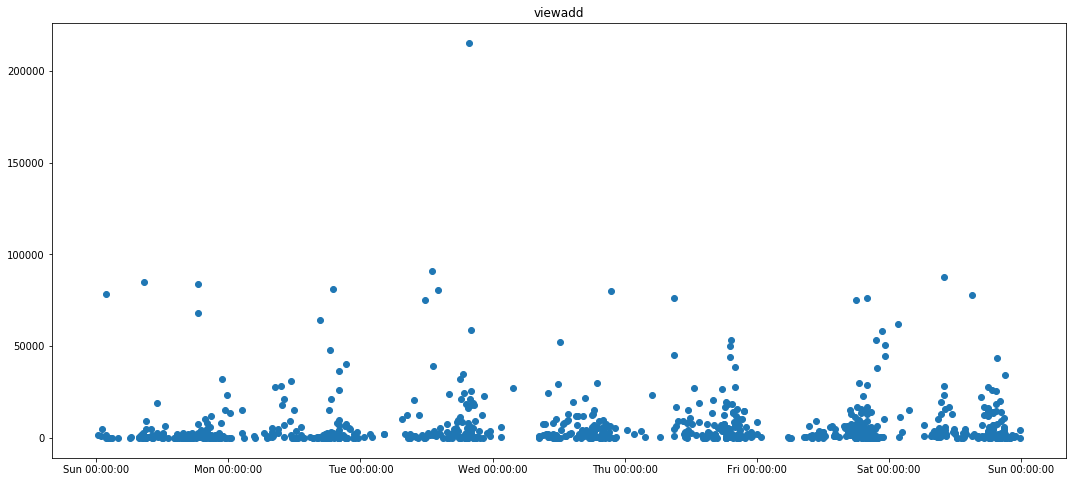

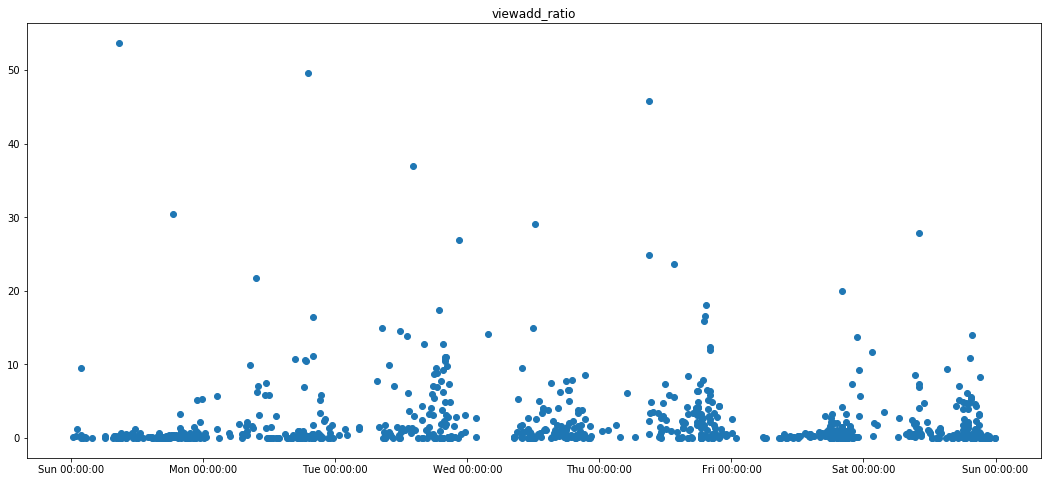

In [33]:
'''view drawing'''
for ii in plt_df.columns[4:6]:
    plt.figure(figsize=(40,8))
    ax = plt.subplot(121)
    plt.plot_date(plt_df.seven, plt_df[ii])
    ax.set_title(ii)
    ax.xaxis.set_major_formatter(DateFormatter('%a %H:%M:%S'))
    ax.xaxis.set_major_locator(AutoDateLocator(maxticks=8)) 
plt.show()

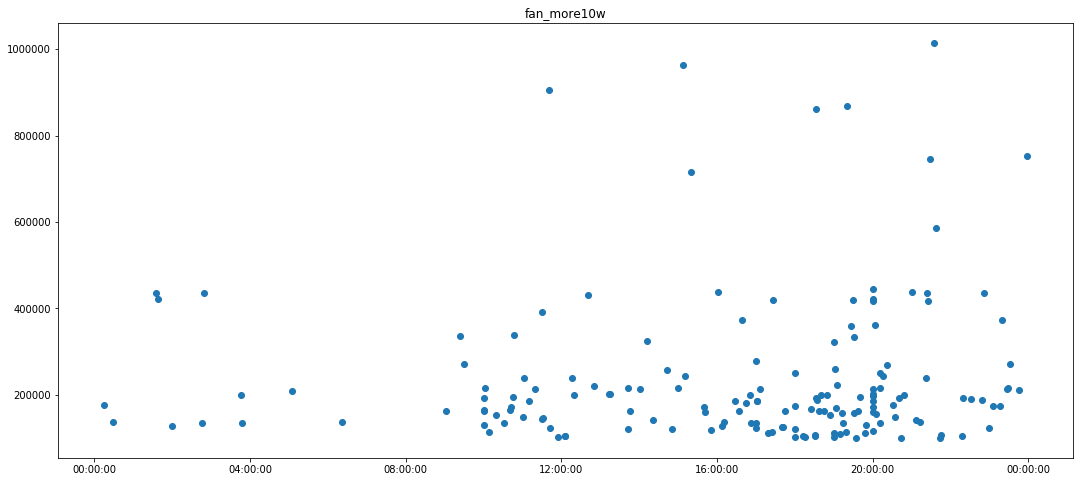

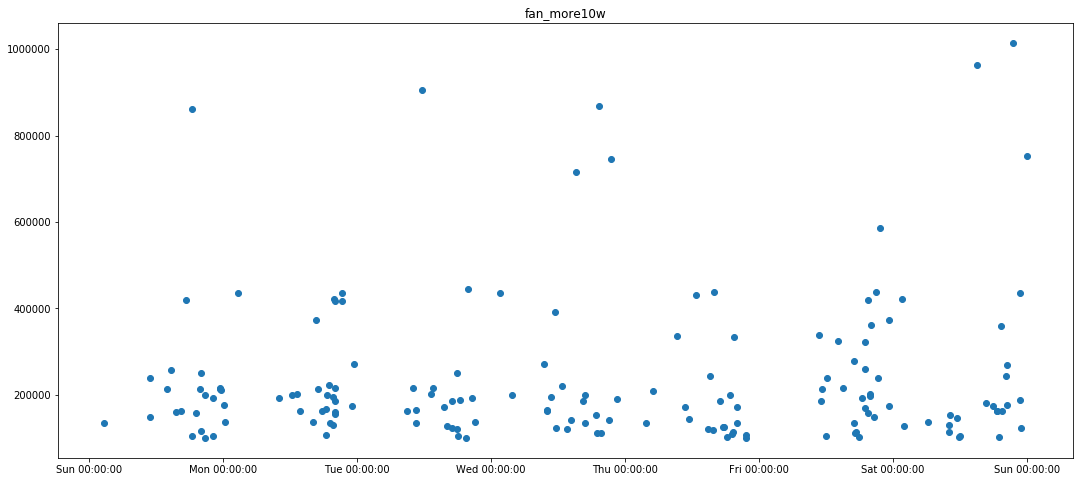

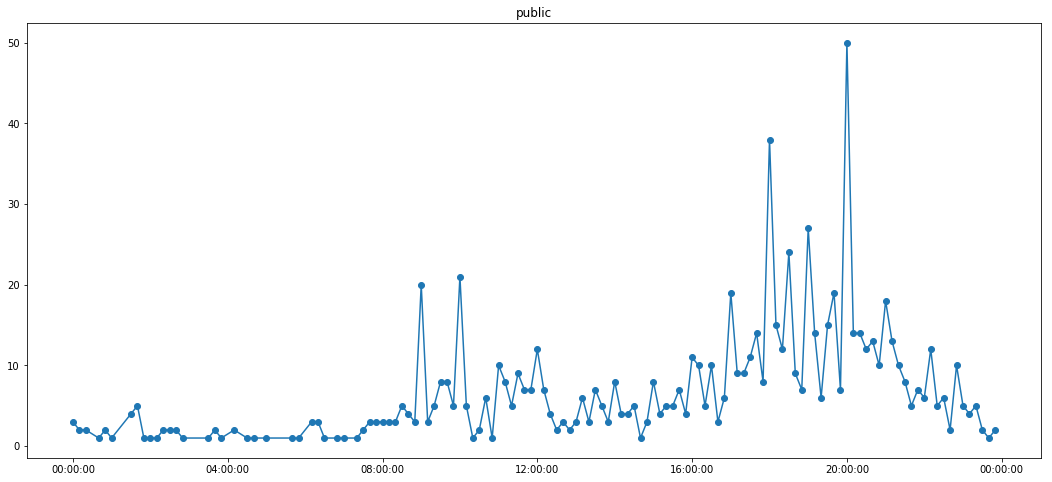

In [54]:
'''drawing fan'''
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter  

plt_df = pd.read_csv('{}public_re.csv'.format(data_dir), parse_dates=['time'])

ii = 'fan_more10w'
plt.figure(figsize=(40,8))
ax = plt.subplot(121)
plt.plot_date(plt_df.time, plt_df[ii])
ax.set_title(ii)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(AutoDateLocator(maxticks=8)) 
plt.show()

plt_df = pd.read_csv('{}public_re.csv'.format(data_dir), parse_dates=['seven'])
plt.figure(figsize=(40,8))
ax = plt.subplot(121)
plt.plot_date(plt_df.seven, plt_df[ii])
ax.set_title(ii)
ax.xaxis.set_major_formatter(DateFormatter('%a %H:%M:%S'))
ax.xaxis.set_major_locator(AutoDateLocator(maxticks=8)) 
plt.show()

plt_df = pd.read_csv('{}public_min.csv'.format(data_dir), parse_dates=['minue'])

minue = pd.DataFrame(plt_df, columns=['minue', 'fan'])
minue = minue.groupby('minue').max()
ii = 'fan'
plt.figure(figsize=(40,8))
ax = plt.subplot(121)
# plt.plot_date(plt_df.minue, plt_df[ii])
plt.plot(minue, 'o-')
ax.set_title('public')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(AutoDateLocator(maxticks=8)) 
plt.show()

